### 1. Import library

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

from torch.utils.data import Dataset,DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image

from tqdm import tqdm
import random

from IPython.display import Image

### 2. check cuda available

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
device

'cuda'

### 3. Dataset

In [4]:
batch_size = 256

In [5]:
train_transform = transforms.Compose([  transforms.Resize(28),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.5], [0.5])])

train_dataset = datasets.MNIST(root="./dataset", train=True, download=True, transform=train_transform)

In [6]:
len(train_dataset)

60000

### 4. DataLoader

In [7]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

### 5. Model Architecture   

- Generator  
- Discriminator 

In [8]:
start_size = 128

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.layer1 = nn.Linear(start_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.layer2 = nn.Linear(256, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.layer3 = nn.Linear(512, 1024)
        self.bn3 = nn.BatchNorm1d(1024)
        self.layer4 = nn.Linear(1024, 512)
        self.bn4 = nn.BatchNorm1d(512)
        self.relu = nn.LeakyReLU(0.1, inplace=True)
        self.tanh = nn.Tanh()
        self.last = nn.Linear(512, 1*28*28)
        
    def forward(self, z):
        z = self.relu(self.layer1(z))
        z = self.relu(self.bn2(self.layer2(z)))
        z = self.relu(self.bn3(self.layer3(z)))
        z = self.relu(self.bn4(self.layer4(z)))
        z = self.tanh(self.last(z))
        z = z.view(z.size(0), 1, 28, 28)
        
        return z

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(1 * 28 * 28, 256),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        flattened = img.view(img.size(0), -1)
        output = self.model(flattened)

        return output

### 6. Loss Function & Optimizer

- Generator
- Discriminator

In [11]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

gen_optim = optim.Adam(generator.parameters(), lr=0.001, betas=(0.5, 0.999))
dis_optim = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

criterion = nn.BCELoss().to(device)

### 7. Train

In [12]:
epochs = 300

for e in range(epochs):
    for i, (imgs, l) in enumerate(train_loader):
        real = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0)
        fake = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0)
        
        real_imgs = imgs.to(device)
        
        # train generator
        gen_optim.zero_grad()
        
        z = torch.normal(mean=0, std=1, size=(imgs.shape[0], start_size)).to(device)
        
        fake_imgs = generator(z)
        
        gen_loss = criterion(discriminator(fake_imgs), real)
        
        gen_loss.backward()
        gen_optim.step()
        
        # train discriminator
        dis_optim.zero_grad()

        real_logits = criterion(discriminator(real_imgs), real)
        fake_logits = criterion(discriminator(fake_imgs.detach()), fake)

        dis_loss = (real_logits + fake_logits) / 2

        dis_loss.backward()
        dis_optim.step()
        
        done = e * len(train_loader) + i
        if e%50 == 0:
            save_image(fake_imgs.data[:25], f"generate_img/{done}.png", nrow=5, normalize=True)
            Image(f"generate_img/{done}.png")
        
    print(f"[Epoch {e}/{epochs}] dis_loss: {dis_loss.item():.6f}, gen_loss: {gen_loss.item():.6f}")

[Epoch 0/300] dis_loss: 0.711621, gen_loss: 0.604549
[Epoch 1/300] dis_loss: 0.675958, gen_loss: 0.683521
[Epoch 2/300] dis_loss: 0.697907, gen_loss: 0.679104
[Epoch 3/300] dis_loss: 0.683818, gen_loss: 0.717553
[Epoch 4/300] dis_loss: 0.677676, gen_loss: 0.683251
[Epoch 5/300] dis_loss: 0.703114, gen_loss: 0.639956
[Epoch 6/300] dis_loss: 0.689548, gen_loss: 0.691673
[Epoch 7/300] dis_loss: 0.701899, gen_loss: 0.704502
[Epoch 8/300] dis_loss: 0.723587, gen_loss: 0.667032
[Epoch 9/300] dis_loss: 0.677767, gen_loss: 0.729972
[Epoch 10/300] dis_loss: 0.728308, gen_loss: 0.649173
[Epoch 11/300] dis_loss: 0.694781, gen_loss: 0.722863
[Epoch 12/300] dis_loss: 0.666240, gen_loss: 0.729376
[Epoch 13/300] dis_loss: 0.624745, gen_loss: 0.684075
[Epoch 14/300] dis_loss: 0.686421, gen_loss: 0.692862
[Epoch 15/300] dis_loss: 0.652480, gen_loss: 0.612224
[Epoch 16/300] dis_loss: 0.694400, gen_loss: 0.718676
[Epoch 17/300] dis_loss: 0.703361, gen_loss: 0.668124
[Epoch 18/300] dis_loss: 0.677844, gen

[Epoch 151/300] dis_loss: 0.517857, gen_loss: 0.904596
[Epoch 152/300] dis_loss: 0.484985, gen_loss: 1.024709
[Epoch 153/300] dis_loss: 0.463480, gen_loss: 1.065097
[Epoch 154/300] dis_loss: 0.548621, gen_loss: 0.903532
[Epoch 155/300] dis_loss: 0.436405, gen_loss: 1.116523
[Epoch 156/300] dis_loss: 0.365415, gen_loss: 1.548401
[Epoch 157/300] dis_loss: 0.525627, gen_loss: 1.107382
[Epoch 158/300] dis_loss: 0.556611, gen_loss: 1.107062
[Epoch 159/300] dis_loss: 0.471915, gen_loss: 1.342646
[Epoch 160/300] dis_loss: 0.407337, gen_loss: 1.225633
[Epoch 161/300] dis_loss: 0.646965, gen_loss: 0.961939
[Epoch 162/300] dis_loss: 0.459261, gen_loss: 1.231954
[Epoch 163/300] dis_loss: 0.614931, gen_loss: 0.798365
[Epoch 164/300] dis_loss: 0.575346, gen_loss: 1.316073
[Epoch 165/300] dis_loss: 0.447005, gen_loss: 1.146598
[Epoch 166/300] dis_loss: 0.410609, gen_loss: 1.109665
[Epoch 167/300] dis_loss: 0.588000, gen_loss: 1.343824
[Epoch 168/300] dis_loss: 0.502433, gen_loss: 0.857594
[Epoch 169

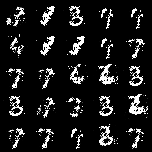

In [13]:
save_image(fake_imgs.data[:25], f"generate_img/{done}.png", nrow=5, normalize=True)
Image(f"generate_img/{done}.png")